In [21]:
%matplotlib inline

# **Tempus Computer Vision Challenge**

As a first attempt, I will see whether it is possible to detect a CSMD3 mutation based on slide images.

## Why CSMD3?
* Has a noticeable effect on prognosis
* Has consistent (same type of disease type and location) slide data

As a dataset, I will start with TCGA-LUAD data. Insert percentage here.

First, let's test the functionality of OpenSlide Python:

3
((25899, 31305), (6474, 7826), (1618, 1956))
(1.0, 4.0002955856136015, 16.00569987184057)


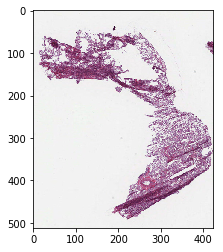

In [22]:
import os
import openslide
import matplotlib.pyplot as plt
import PIL
import numpy as np

# Pick the folder containing mutation positive data
root = 'TCGA_LUAD_CSMD3pos'

# Navigate to first folder and first file
foldernames = os.listdir(root)
file = os.path.join(root,foldernames[0],os.listdir(os.path.join(root,foldernames[0]))[0])

# Open the image
slide = openslide.OpenSlide(file)
# Print number of embedded images and their resolutions
print(slide.level_count)
print(slide.level_dimensions)
print(slide.level_downsamples)

# View a thumbnail
plt.imshow(slide.get_thumbnail((512,512)))
plt.show()

The interface works perfectly!

Moving forward, first thing to test is probably a rough prototype with a simple model to see whether we get above-baseline accuracy. Some considerations:
* Images are large, sparse and varied in size. Downsampling to a 'reasonable' size will probably throw out too much information, and we will be left with an image that's still empty space for most of it.
* Instead, I'm going to try tiling. I can pick a standard tile size, scale the image to its nearest multiple, and feed tiles from the image into the first prototype model.
* In this setup, I can probably throw out many tiles if I include a simple empty tile detector as pre-processing. This should be easily doable through thresholding the average pixel value, as sparse regions are quite sparse. Can pick the threshold value such that partially empty tiles that have enough content to warrant analysis will be included.
* However, a tile-based approach introduces a few complications - there will be different number of total tiles per image, and not all tiles might have information on the mutation even if it's a filled tile. After all, we don't even know how the mutation manifests (if it manifests at all. If it doesn't... well we won't get accuracy above pure chance.)
* Not sure if color is actually important given how the staining is. I will test RGB vs grayscale.

Given the above, as a first pass I will try filtered tiles of 512x512. All tiles that are below a certain threshold (so not too empty) from a given sample will be passed through a CNN, and a final maxpool will determine the classification for that sample. The idea is that only a small region might exhibit anomalies due to the mutation and in this case most regions could spit out '0' and some regions might spit out '1', and we want to correctly classify this as mutated overall. This is also agnostic to number of tiles used, so we get around that problem as well.


Let's start with playing around the OpenSlide interface to come up with tiling.

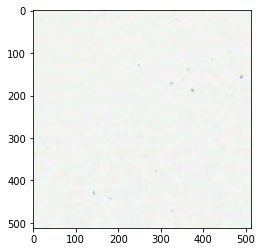

242.1392364501953


In [50]:
# Tiling can probably be done using the read_region functionality
# Let's test a random 'tile' at 1,3
tile_size = 512
tile_nr = [1,3]

plt.imshow(slide.read_region((tile_nr[0]*tile_size,tile_nr[1]*tile_size),0,(tile_size,tile_size)))
plt.show()

# Let's create a function that returns a tile given slide, location and size.
def fetch_tile(slide,location,size,downsample=1,offset=[0,0]):
    '''
    Returns a tile as PIL image given a openslide slide, location in X,Y tile space, and tile size (assumed to be square)
    '''
    return slide.read_region((location[0]*size,location[1]*size),
                             slide.get_best_level_for_downsample(downsample),
                             (size+offset[0],size+offset[1]))


# Tile 1,3 is mostly empty. What's the average pixel value in grayscale?
grayscale = fetch_tile(slide,tile_nr,tile_size).convert('L')
print(np.average(grayscale))

Average pixel value is (expectedly) very close to pure white, which is 255 for this type of image. Let's set a threshold of half - 128 - and display the first image that is below the threshold.

(12, 15)


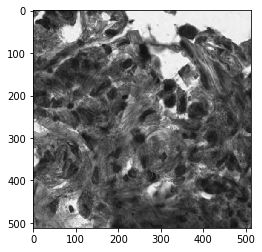

5 8


In [55]:
import itertools

# Set the threshold and level.
threshold = 128
downsample = 1

# Set the bounds as tuple
bounds = tuple(int(dim/tile_size) for dim in slide.level_dimensions[level])
print(bounds)

# Loop and find the first tile which is below the threshold
for i,j in itertools.product(range(bounds[0]),range(bounds[1])):
    image = fetch_tile(slide,[i,j],tile_size).convert('L')
    if np.average(image) < threshold:
        plt.imshow(image)
        plt.show()
        print(i,j)
        break
        



That slide is completely occupied. Perhaps a higher threshold will be better. Let's try 200.

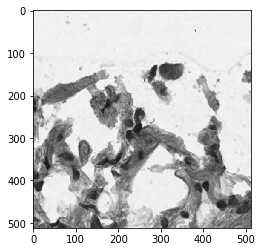

2 11


In [56]:
# Try a different threshold value
threshold = 200

# Loop and find the first tile which is below the threshold
for i,j in itertools.product(range(bounds[0]),range(bounds[1])):
    image = fetch_tile(slide,[i,j],tile_size).convert('L')
    if np.average(image) < threshold:
        plt.imshow(image)
        plt.show()
        print(i,j)
        break

The above seems serviceable for a first attempt. Let's throw together a data loader with the thresholding.

In [141]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class SlidesDataset(Dataset):
    '''
    A dataset class to fetch slide images.
    
    '''
    
    def __init__(self,pos_path,neg_path,threshold,tile_size,transform=None,downsample=1):
        self.pos_path = pos_path
        self.neg_path = neg_path
        self.transform = transform
        self.threshold = threshold
        self.downsample = downsample
        self.tile_size = tile_size
        
        self.pos_length = 0
        for root, dirs, files in os.walk(self.pos_path):
            for name in files:
                if name.endswith(('.svs')):
                    self.pos_length = self.pos_length + 1
                    
        self.neg_length = 0
        for root, dirs, files in os.walk(self.neg_path):
            for name in files:
                if name.endswith(('.svs')):
                    self.neg_length = self.neg_length + 1
        
    def __len__(self):
        return self.pos_length+self.neg_length
                    
    def __getitem__(self,idx):        
        if idx < self.pos_length:
            classification = 1
            files = os.listdir(os.path.join(self.pos_path,os.listdir(self.pos_path)[idx]))
            for file in files:
                if file.endswith(('.svs')):
                    finalpath = os.path.join(self.pos_path,os.listdir(self.pos_path)[idx],file)
        else:
            classification = 0
            files = os.listdir(os.path.join(self.neg_path,os.listdir(self.neg_path)[idx-self.pos_length]))
            for file in files:
                if file.endswith(('.svs')):
                    finalpath = os.path.join(self.neg_path,os.listdir(self.neg_path)[idx-self.pos_length],file)
                        
        tiles=[]
        try:
            slide = openslide.OpenSlide(finalpath)
        except:
            print(finalpath)
            
        level = slide.get_best_level_for_downsample(self.downsample)
        bounds = tuple(int(dim/self.tile_size) for dim in slide.level_dimensions[level])
        
        for i,j in itertools.product(range(bounds[0]),range(bounds[1])):
            #tick = time.perf_counter()

            image = fetch_tile(slide,[i,j],self.tile_size,downsample=self.downsample).convert('L')
           # print('fetching:',time.perf_counter()-tick)
           # tick = time.perf_counter()
            if np.average(image) < self.threshold:
                tile = image
                if self.transform:
                    tile = self.transform(tile)
                tiles.append(tile)
                
            #print('appending:',time.perf_counter()-tick)
        slide.close()
                
        return {'tiles': tiles, 'class': classification,'length':len(tiles),'filename':finalpath,'level':level}

In [142]:
test_dataset = SlidesDataset('TCGA_LUAD_CSMD3pos','TCGA_LUAD_CSMD3neg',230,1024,downsample=1)
print(len(test_dataset))

for i in range(len(test_dataset)):
    if i % 10 == 0:
        print(i)
        datapoint = test_dataset[i]
        tiles = datapoint['tiles']
        print('Number of tiles:',len(tiles))
        print('Image source:',datapoint['filename'])
        print('Level:',datapoint['level'])
        subplots = int(len(tiles)/50+1)
        fig, axes = plt.subplots(nrows=1,ncols=subplots,squeeze=False)
        for j in range(len(tiles)):
            if j % 50 == 0:
                axes[0,int(j/50)].imshow(tiles[j],cmap='gray')
                #fig.add_subplot(plt.imshow(datapoint[j]))
                axes[0,int(j/50)].set_title(str(i)+' '+str(j))
        plt.show()
        

39
0


KeyboardInterrupt: 

Dataloader seems to work alright for now. Thresholding operation is somewhat slow. Remains to be seen whether I need to optimize anything thus far. Let's set up a simple CNN and start training. Even in the underfitting regime, we could get an answer to whether this is even possible to do.

In [146]:
import torch.nn as nn

# Enable GPU training if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(1,32,4)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32,32,4)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32,32,4)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.linear1 = nn.Linear(13*13*32,32)
        self.linear2 = nn.Linear(32,1)
    
    def forward(self,x):
        y = self.conv1(x)
        y = self.batchnorm1(nn.functional.relu(y))
        y = self.maxpool1(y)
        y = self.conv2(y)
        y = self.batchnorm2(nn.functional.relu(y))
        y = self.maxpool2(y)
        y = self.conv3(y)
        y = self.batchnorm3(nn.functional.relu(y))
        y = self.maxpool3(y)
        y = self.linear1(y.view(-1,13*13*32))
        y = torch.sigmoid(self.linear2(nn.functional.relu(y)))
        return y

#device='cpu'
model = ConvNet().to(device)
#criterion = BinaryCr
        

In [134]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0],std=[1.0])])
dataset = SlidesDataset('TCGA_LUAD_CSMD3pos','TCGA_LUAD_CSMD3neg',200,1024,transform)
#test_img = dataset[0]['tiles'][0]

In [143]:
#print(test_img.to(device))
print(model(test_img.to(device).unsqueeze(0)))
print(model(test_img.to(device).unsqueeze(0)).shape)

torch.Size([1, 1, 128, 128])
tensor([[0.2809]], device='cuda:0', grad_fn=<SigmoidBackward>)
torch.Size([1, 1, 128, 128])
torch.Size([1, 1])


In [148]:
train_dataloader = torch.utils.data.DataLoader(dataset=dataset,batch_size=1,shuffle=True)
#for i, sample in enumerate(train_dataloader):
#    print(sample)
#    print(len(sample['tiles']))
#    break

In [156]:
import time

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

epoch_length = len(train_dataloader)
batch_size = 1
optimizer_step = 1
num_epochs = 1
#tick = time.perf_counter()



batch_loss = 0.0
epoch_loss = 0.0
for epoch in range(num_epochs):
    for i, sample in enumerate(train_dataloader):
        if sample['length'] > 0:
            target_labels = torch.empty((batch_size),device=device)
            predicted_labels = torch.empty((batch_size),device=device) 
            
            fulltiles = torch.empty((sample['length'],1,128,128))       
            torch.cat(sample['tiles'],out=fulltiles)
            
            tile_predictions = model(fulltiles.to(device))      
            predicted_labels[i%batch_size] = torch.max(tile_predictions)
            target_labels[i%batch_size] = sample['class']
            
            loss=loss_function(predicted_labels,target_labels)
            loss.backward()       
            batch_loss = batch_loss + loss.item()

            if i%batch_size == 0 or i == (epoch_length-1):            
                optimizer.step()
                optimizer.zero_grad()
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
.format(epoch+1, num_epochs, i+1, epoch_length, batch_loss))
                epoch_loss = epoch_loss + batch_loss
                batch_loss = 0.0
            
    print('Epoch {} finished. Epoch total loss is: {:.4f}'.format(epoch+1,epoch_loss))
        

    

Epoch [1/1], Step [1/39], Loss: 0.6177
Epoch [1/1], Step [2/39], Loss: 0.6799
Epoch [1/1], Step [3/39], Loss: 0.7316
Epoch [1/1], Step [4/39], Loss: 0.7777
Epoch [1/1], Step [5/39], Loss: 0.7776
Epoch [1/1], Step [6/39], Loss: 0.7555
Epoch [1/1], Step [7/39], Loss: 1.0828
Epoch [1/1], Step [8/39], Loss: 0.6336
Epoch [1/1], Step [9/39], Loss: 0.7197
Epoch [1/1], Step [10/39], Loss: 0.7474
Epoch [1/1], Step [11/39], Loss: 0.7419
Epoch [1/1], Step [12/39], Loss: 0.6910
Epoch [1/1], Step [13/39], Loss: 0.7003
Epoch [1/1], Step [14/39], Loss: 0.6062
Epoch [1/1], Step [15/39], Loss: 0.6371
Epoch [1/1], Step [16/39], Loss: 0.6756
Epoch [1/1], Step [17/39], Loss: 0.6581
Epoch [1/1], Step [18/39], Loss: 0.7496
Epoch [1/1], Step [19/39], Loss: 0.7733
Epoch [1/1], Step [20/39], Loss: 0.4840
Epoch [1/1], Step [21/39], Loss: 0.6267
Epoch [1/1], Step [22/39], Loss: 1.2504
Epoch [1/1], Step [23/39], Loss: 1.0164
Epoch [1/1], Step [24/39], Loss: 0.7527
Epoch [1/1], Step [25/39], Loss: 0.9660
Epoch [1/